## Data Collection and Feature Engineering steps

In [ ]:
from IPython.display import clear_output
!pip install transformers[torch]
clear_output()

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

# Map the new labels to their original emotion names
emotions_dict = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def map_emotions(data):
    emotion_mapping = {
        "admiration": "positive_intent", "amusement": "positive_intent", "anger": "negative_intent", "annoyance": "negative_intent",
        "approval": "positive_intent", "caring": "positive_intent", "confusion": "inquiry", "curiosity": "inquiry",
        "desire": "positive_intent", "disappointment": "negative_intent", "disapproval": "negative_intent", "disgust": "negative_intent",
        "embarrassment": "negative_intent", "excitement": "positive_intent", "fear": "urgency", "gratitude": "positive_intent",
        "grief": "negative_intent", "joy": "positive_intent", "love": "positive_intent", "nervousness": "urgency",
        "optimism": "positive_intent", "pride": "positive_intent", "realization": "inquiry", "relief": "positive_intent",
        "remorse": "negative_intent", "sadness": "negative_intent", "surprise": "positive_intent", "neutral": "neutral"
    }
    category_to_int_mapping = {
        "neutral": 0, "negative_intent": 1, "positive_intent": 2, "inquiry": 3, "urgency": 4
    }
    def map_emotion(emotion_id):
        original_emotion = emotions_dict.get(int(emotion_id), 'other')
        category = emotion_mapping.get(original_emotion, 'other')
        return category_to_int_mapping.get(category, -1)  # Use -1 for any unmapped categories
    data['emotion'] = data['emotion'].apply(map_emotion)
    return data

def sample_data(data, fraction=1.0):
    return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)

def tokenize_data(comments):
    # Tokenize using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

# URLs for train and validation data
train_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv'
validation_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'

# Process train data
train_data = load_data(train_data_url)
train_data = preprocess_data(train_data)
train_data = map_emotions(train_data)
sampled_train_data = sample_data(train_data)

# Process validation data
validation_data = load_data(validation_data_url)
validation_data = preprocess_data(validation_data)
validation_data = map_emotions(validation_data)
sampled_validation_data = sample_data(validation_data)

# Tokenize the comments
train_tokenized_comments = tokenize_data(sampled_train_data['comment'].to_list())
validation_tokenized_comments = tokenize_data(sampled_validation_data['comment'].to_list())

# Prepare training data
X_train = train_tokenized_comments['input_ids']
attention_masks_train = train_tokenized_comments['attention_mask']
y_train = torch.tensor(sampled_train_data['emotion'].values)

# Prepare validation data
X_validation = validation_tokenized_comments['input_ids']
attention_masks_validation = validation_tokenized_comments['attention_mask']
y_validation = torch.tensor(sampled_validation_data['emotion'].values)

print()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique:", np.unique(y_train))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


X_train shape: torch.Size([36307, 316])
y_train shape: torch.Size([36307])
y_train unique: [0 1 2 3 4]


# 1. Model Building

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

### Initialization

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def print_device_info(device):
    print(f"Using device: {device}")
    if device.type == "cuda":
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    elif device.type == "mps":
        torch.mps.empty_cache()
        print(f"MPS memory allocated: {torch.mps.current_allocated_memory() / 1e9:.2f} GB")
    elif device.type == "cpu":
        print("No GPU available. Using CPU.")

device = get_device()
print_device_info(device)

Using device: cuda
CUDA Device: Tesla T4
CUDA memory allocated: 0.00 GB


### Define the model

In [ ]:
from transformers import BertForSequenceClassification
# Load the BERT model
# we will use the bert-base-uncased model
# this model will classify the comments into 10 emotions

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device);  # Move the model to the GPU

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the emotion dataset

In [ ]:
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback


# Create a Dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Prepare datasets
train_dataset = EmotionDataset(X_train, attention_masks_train, y_train)
validation_dataset = EmotionDataset(X_validation, attention_masks_validation, y_validation)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Directory to save the model checkpoints
    num_train_epochs=3,  # Total number of training epochs
    per_device_train_batch_size=32,  # Batch size per device during training
    per_device_eval_batch_size=32,  # Batch size for evaluation
    warmup_steps=50,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Strength of weight decay
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every X updates steps
    evaluation_strategy="steps",  # Evaluate the model every X steps
    save_strategy="steps",  # Save the model checkpoint every X steps
    save_steps=0,  # Steps interval for saving model checkpoint (We dont need to save steps)
    eval_steps=10,  # Steps interval for evaluation
    gradient_accumulation_steps=2,  # Number of updates steps to accumulate before performing a backward/update pass
    fp16=True,  # Use 16-bit (mixed) precision training
    learning_rate=3e-5,  # The initial learning rate for AdamW optimizer
    load_best_model_at_end=True,  # Load the best model when finished training (default metric is loss)
    lr_scheduler_type="reduce_lr_on_plateau",  # Learning rate scheduler type
    metric_for_best_model="eval_loss",  # Use loss to identify the best model
    save_total_limit=2,  # Limit the total amount of checkpoints. Deletes the older checkpoints.
    greater_is_better=False,  # Set to True if the metric to optimize is greater (e.g. Accuracy, F1). False for metrics which are lower (e.g. loss)
    # no_cuda=True if device.type != 'cuda' else False,  # Do not use CUDA even when available
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss
10,1.419300,1.294664
20,1.299000,1.187741
30,1.172800,1.098360
40,1.102300,1.019365
50,1.014200,1.006915
60,0.983800,0.998334
70,0.992300,0.898988
80,0.916300,0.897440
90,0.841000,0.866004
100,0.842000,0.844399


TrainOutput(global_step=1701, training_loss=0.6810853263338057, metrics={'train_runtime': 2483.7187, 'train_samples_per_second': 43.854, 'train_steps_per_second': 0.685, 'total_flos': 1.7674554209142576e+16, 'train_loss': 0.6810853263338057, 'epoch': 2.9973568281938325})

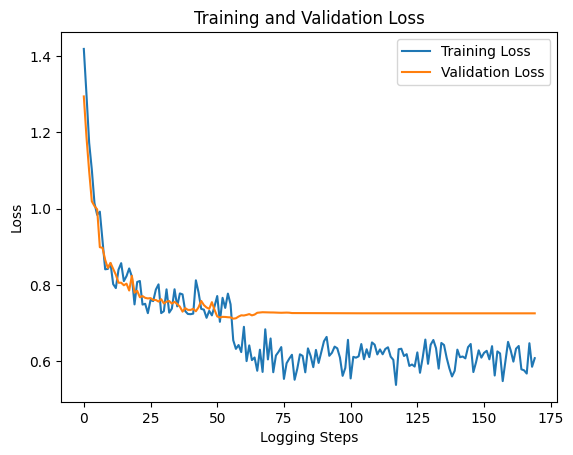

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the logs
train_losses = []
eval_losses = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Save Model (only from google drive)

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os

# project_name = "NMA-GoEmotions-Project"
# model_save_path = f'/content/drive/MyDrive/@NMA_Projects/{project_name}/{project_name}/model'

# source_path = './results/'

# # Create the destination directory if it doesn't exist
# os.makedirs(model_save_path, exist_ok=True)

# # Save only the classification layer weights
# classifier_weights = model.classifier.state_dict()
# torch.save(classifier_weights, os.path.join(model_save_path, 'classifier_weights_bert.pt'))

# print(f"Model copied to Google Drive at: {model_save_path}")

Model copied to Google Drive at: /content/drive/MyDrive/@NMA_Projects/NMA-GoEmotions-Project/NMA-GoEmotions-Project/model
